In [0]:
'''trained_model = models.vgg16(pretrained=True)
trained_model

classifier_name, old_classifier = trained_model._modules.popitem()
print(classifier_name,'\n',old_classifier)
#add new hidden and dropout layers at the end
classifier_input_size = old_classifier[0].in_features
print(classifier_input_size)
classifier = nn.Sequential(OrderedDict([('drop1', nn.Dropout(p=0.45)),
                                           ('leakyrelu1', nn.LeakyReLU(0.8)),
                                           ('fc1', nn.Linear(classifier_input_size, 1))
                                           ]))

trained_model.add_module(classifier_name, classifier)

if train_on_gpu:
  print('moving')
  trained_model.cuda()

trained_model'''

In [1]:
# to read files from google drive, in case you're running on colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
data_dir = './drive/My Drive/gan_task/'
train_dir = data_dir

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
from torchvision import transforms, datasets, models
import numpy as np
from collections import OrderedDict
import os
import matplotlib.pyplot as plt
import pickle as pkl

%matplotlib inline

train_on_gpu = torch.cuda.is_available()

In [3]:
print(len(os.listdir(data_dir+'1000px/')))

193


In [0]:
# loading all images into training and validation dataset
batch_size = 12
data_transforms = transforms.Compose([transforms.Resize((512, 512)),
                                transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [0]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    Y = feature_range[0]
    X = feature_range[1] - feature_range[0]
    x = x * X + Y
    
    return x

In [0]:
def gaussian_noise(ins, mean, stddev, is_training = True):
  if is_training:
    noise = torch.zeros(ins.shape, dtype=torch.float).cuda().detach()
    torch.nn.init.xavier_uniform_(noise)
    #noise = Variable(ins.data.new(ins.size()).normal_(mean, stddev))
    return ins + noise
  return ins

In [0]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    # append conv layer
    layers.append(conv_layer)
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [0]:
class Discriminator(nn.Module):
    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim
        
        # complete init function
        self.conv1 = conv(3, self.conv_dim, 2, padding =0, batch_norm = False)
        self.conv2 = conv(self.conv_dim, self.conv_dim * 2, 4)
        self.conv3 = conv(self.conv_dim * 2, self.conv_dim * 4, 4)
        self.conv4 = conv(self.conv_dim * 4, self.conv_dim * 4, 4)
        self.conv5 = conv(self.conv_dim * 4, self.conv_dim * 16, 4)
        #self.conv5_1 = conv(self.conv_dim * 16, self.conv_dim * 16, 4, stride=1, padding=1)
        self.conv6 = conv(self.conv_dim * 16, self.conv_dim * 32, 4)
        
        self.fc = nn.Linear(self.conv_dim * 32 * 8 * 8, 1)

    def forward(self, x):
        # complete forward function
        x = gaussian_noise(x, 0, 0.0001)
        x = F.leaky_relu(self.conv1(x))
        #print('x shape =', x.shape)
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        #x = gaussian_noise(x, 0, 0.0001)
        x = F.leaky_relu(self.conv4(x), 0.3)
        #x = gaussian_noise(x, 0, 0.0001)
        x = F.leaky_relu(self.conv5(x), 0.4)
        #print('shape before =', x.shape)
        #x = F.leaky_relu(self.conv5_1(x), 0.4)
        #print('shape after =', x.shape)
        x = F.leaky_relu(self.conv6(x), 0.4)
        #print('x shape right before fc =', x.shape)
        x = x.view(-1, self.conv_dim * 32 * 8 * 8)
        x = self.fc(x)
        
        #x = trained_model(x)
        
        return x

In [0]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    layers = []
    deconv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias = False)
    layers.append(deconv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [0]:

class Generator(nn.Module):    
    def __init__(self, z_size, conv_dim):
        super(Generator, self).__init__()
        self.conv_dim = conv_dim
        self.drop = nn.Dropout(0.5)
        self.fc = nn.Linear(z_size, conv_dim * 16 * 16 * 16)
        
        self.pixel_shuffle = nn.PixelShuffle(2)
        
        #self.de_conv1 = deconv(conv_dim * 16, conv_dim * 8, 4)
        #self.de_conv2 = deconv(conv_dim * 8, conv_dim * 4, 4)
        self.de_conv3 = deconv(conv_dim * 4, conv_dim * 4, 4)
        self.de_conv4 = deconv(conv_dim * 4, conv_dim * 2, 4)
        
        
        self.de_conv5 = deconv(conv_dim * 2, conv_dim, 4)
        self.de_conv6 = deconv(conv_dim, 3, 2, padding=0, batch_norm = False)

    def forward(self, x):
        # complete forward function
        x = F.leaky_relu(self.fc(x))
        x = self.drop(x)
        x = x.view(-1, self.conv_dim*16, 16, 16)
        
        x = F.relu(self.pixel_shuffle(x))
        #x = F.leaky_relu(self.de_conv1(x), 0.2)
        #x = F.leaky_relu(self.de_conv2(x), 0.2)
        x = F.relu(self.de_conv3(x))
        x = F.relu(self.de_conv4(x))
        x = self.drop(x)
        x = F.leaky_relu(self.de_conv5(x), 0.2)
        x = torch.tanh(self.de_conv6(x))
        
        return x

In [0]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__    
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.xavier_normal_(m.weight.data)
    

In [12]:
# define hyperparams
conv_dim = 128
z_size = 128

# define discriminator and generator
D = Discriminator(conv_dim)
G = Generator(z_size=z_size, conv_dim=conv_dim)

D.apply(weights_init_normal)
G.apply(weights_init_normal)
'''print(D)
print()
print(G)'''

'print(D)\nprint()\nprint(G)'

In [0]:
def real_loss(D_out, flip=False):
    batch_size = D_out.size(0)
    #labels = torch.ones(batch_size) # real labels = 1
    labels = torch.rand(batch_size).uniform_(0.7, 1.2) # real labels = random numbers between 0.7 and 1.2
    if flip:
      labels = torch.rand(batch_size).uniform_(0, 0.3) # real labels = random numbers between 0 and 0.3
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    #print(D_out.shape, labels.shape)
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    #labels = torch.zeros(batch_size) # fake labels = 0
    labels = torch.rand(batch_size).uniform_(0, 0.3) # fake labels = random numbers between 0 and 0.3
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [0]:
# params
lr_d = 0.0005
lr_g = 0.0005
beta1= 0.5
beta2= 0.999

# Create optimizers for the discriminator and generator
# use momentum here?
d_optimizer = optim.SGD(D.parameters(), lr_d, momentum = 0.3)
g_optimizer = optim.Adam(G.parameters(), lr_g, [beta1, beta2])

In [15]:
if train_on_gpu:
    # move models to GPU
    G.cuda()
    D.cuda()
    print('GPU available for training. Models moved to GPU')

GPU available for training. Models moved to GPU


In [16]:
import pickle as pkl
import random

# training hyperparams
num_epochs = 400

# keep track of loss and generated, "fake" samples
samples = []
losses = []

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size = 2
fixed_z = torch.zeros((sample_size, z_size), dtype=torch.float).cuda()
torch.nn.init.xavier_normal_(fixed_z)
if train_on_gpu:
    fixed_z = fixed_z.cuda()

# train the network
for epoch in range(num_epochs):
    d_loss_net = g_loss_net = 0
    batch_count = 0
    for real_images, _ in train_loader:
        if real_images.shape[0] < batch_size:
            continue
      
        batch_count += 1
        batch_size = real_images.size(0)
        real_images = scale(real_images)
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================

        d_optimizer.zero_grad()

        # 1. Train with real images

        # Compute the discriminator losses on real images 
        if train_on_gpu:
            real_images = real_images.cuda()

        D_real = D(real_images)
        d_real_loss = real_loss(D_real)

        # 2. Train with fake images

        # Generate fake images
        z = torch.zeros((batch_size, z_size), dtype=torch.float).cuda()
        torch.nn.init.xavier_normal_(z)
        # move x to GPU, if available
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)

        # Compute the discriminator losses on fake images 
        #print('fake image shape =', fake_images.shape)
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)

        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss_net += d_loss.item() / batch_size
        d_loss.backward()
        d_optimizer.step()


        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()

        # 1. Train with fake images and flipped labels

        # Generate fake images
        z = torch.zeros((batch_size, z_size), dtype=torch.float).cuda()
        torch.nn.init.xavier_normal_(z)
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)

        # Compute the discriminator losses on fake images 
        # using flipped labels!
        # set D to eval?
        D_fake = D(fake_images)
        
        #flip = random.randint(0, 3) == 2
        amp_factor = 1.2
        g_criterion_new = nn.MSELoss()
        g_loss = real_loss(D_fake) + amp_factor * g_criterion_new(fake_images, real_images) # use real loss
        g_loss_net += g_loss.item() / batch_size
        # perform backprop
        g_loss.backward()
        g_optimizer.step()
           
    if epoch % 100 == 0:
      # generate and save sample, fake images
      G.eval() # for generating samples
      samples_z = G(fixed_z)
      samples.append(samples_z.detach())
    G.train() # back to training mode
    
    # Print some loss stats
    # append discriminator loss and generator loss
    #losses.append((sum(d_loss_all)/len(d_loss_all), sum(g_loss_all)/len(g_loss_all)))
    # print discriminator and generator loss
    print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
            epoch+1, num_epochs, d_loss_net / batch_count, g_loss_net / batch_count))
    #torch.cuda.empty_cache()

Epoch [    1/  400] | d_loss: 0.3937 | g_loss: 0.0684
Epoch [    2/  400] | d_loss: 0.4652 | g_loss: 0.0613
Epoch [    3/  400] | d_loss: 0.4960 | g_loss: 0.0712
Epoch [    4/  400] | d_loss: 0.4971 | g_loss: 0.0898
Epoch [    5/  400] | d_loss: 0.5111 | g_loss: 0.1466
Epoch [    6/  400] | d_loss: 0.2905 | g_loss: 0.3953
Epoch [    7/  400] | d_loss: 0.3254 | g_loss: 0.5072
Epoch [    8/  400] | d_loss: 0.4737 | g_loss: 0.7347
Epoch [    9/  400] | d_loss: 0.3757 | g_loss: 0.7207
Epoch [   10/  400] | d_loss: 0.4297 | g_loss: 0.6492
Epoch [   11/  400] | d_loss: 0.3347 | g_loss: 0.6313
Epoch [   12/  400] | d_loss: 0.3037 | g_loss: 0.5786
Epoch [   13/  400] | d_loss: 0.1929 | g_loss: 0.5074
Epoch [   14/  400] | d_loss: 0.2570 | g_loss: 0.5167
Epoch [   15/  400] | d_loss: 0.2290 | g_loss: 0.4554
Epoch [   16/  400] | d_loss: 0.2143 | g_loss: 0.4504
Epoch [   17/  400] | d_loss: 0.1978 | g_loss: 0.4409
Epoch [   18/  400] | d_loss: 0.1771 | g_loss: 0.3695
Epoch [   19/  400] | d_loss

In [0]:
# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

In [0]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(20,20), nrows=2, ncols=1, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((512,512,3)))

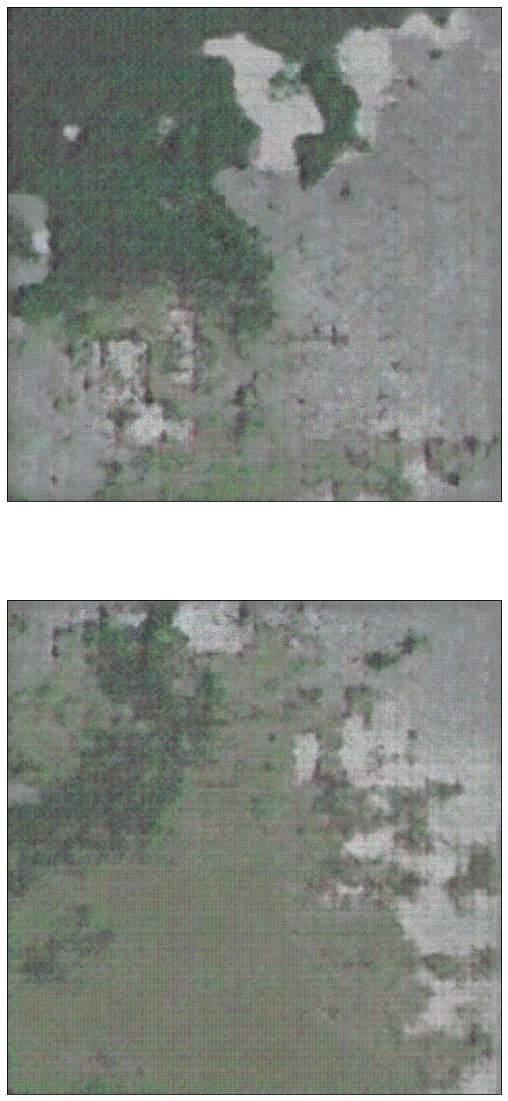

In [19]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples(-1, samples)

IndexError: ignored

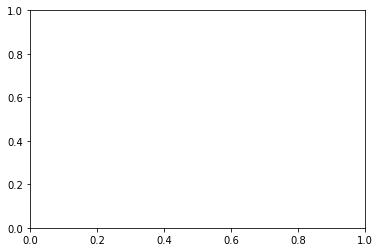

In [20]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()